# IAU Projekt

# Fáza 2 - predspracovanie údajov

V tejto fáze sa od Vás očakáva:
* Realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada vo formáte csv alebo tsv, kde jedno pozorovanie musí byť opísané jedným riadkom.
* V 3. fáze budeme pracovať s algoritmami strojového učenia, ktorých implementácia v scikit-learn podporuje len numerické dáta. To vedie k tomu že treba niečo spraviť s nenumerickými dátami.
* Replikovateľnosť predspracovania na trénovacej a testovacej množine dát.

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby. Bodovanie znovu za EDA už nebudeme, zmeny ale zdokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa vlastnej potreby.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
def load_data(path_labor, path_personal):
    labor = pd.read_csv(path_labor, sep='\t')
    labor.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
    labor = labor.drop(["index", "name"], axis=1)
    smoker_encoding = {"Y": 1, "N": 0, "yes": 1, "no": 0}
    labor["smoker"].replace(smoker_encoding, inplace=True)
#     relationship_encoding = {"divoced": 1, "married": 2, "single": 3, "nop": 4, "widowed": 5, "separated": 6}
#     labor["relationship"].reaplace(relationship_encoding, inplace=True)
    labor = labor.drop(["relationship"], axis=1)
    
    profiles = pd.read_csv(path_personal, sep='\t')
    profiles = profiles.drop(["residence", "job", "company", "name"], axis=1)
    profiles["race"].replace({"black": "Black", "white": "White", "blsck": "Black"}, inplace=True)
    
    race_encoding = {"White": 1, "Black": 2, "Asian": 3, "Hawaiian":4, "Indian": 5}
    profiles["race"].replace(race_encoding, inplace=True)

    profiles["birthdate"] = pd.to_datetime(profiles['birthdate'], utc=False)
    
    blood_encoding = {"A-": 1, "A+": 2, "B-": 3, "B+": 4, "O-": 5, "O+": 6, "AB-": 7, "AB+": 8}
    profiles["blood_group"].replace(blood_encoding, inplace=True)

    sex_encoding = {"M": 0, "F": 1}
    profiles["sex"].replace(sex_encoding, inplace=True)
    
    merged = pd.merge(profiles, labor, how='outer', on='ssn')
    
    return merged

In [3]:
data = load_data("046/labor.csv", "046/profiles.csv")

In [4]:
data.head()

,Unnamed: 0,race,birthdate,blood_group,sex,ssn,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,ast,trombocyty
0,0,1,2007-09-11,6,1,087-49-2961,68.64852,7.26815,68.18352,5.81889,2.66285,6.93051,6.07205,11.27999,0.0,44.47642,8.86713,0,26.77151,5.62532
1,0,1,2007-09-11,6,1,087-49-2961,39.27363,5.09400,58.42059,5.99564,1.43578,6.54612,9.31958,11.65206,1.0,57.12059,10.57140,0,38.28069,6.59275
2,0,1,2007-09-11,6,1,087-49-2961,61.21115,9.10298,14.51194,10.27253,2.13866,6.91541,5.98328,9.13539,1.0,16.95110,7.30150,0,52.93857,8.58363
3,0,1,2007-09-11,6,1,087-49-2961,121.34568,9.03854,11.04396,5.55113,1.35987,6.49755,6.91512,8.46192,0.0,63.86999,8.47060,0,48.94005,7.28386
4,1,3,1971-05-20,1,1,704-69-2733,107.36307,7.43673,68.85609,5.90077,3.45904,7.88035,7.00488,5.96198,1.0,42.66862,6.25355,0,60.53571,9.03697


## 1. Integrácia a čistenie dát (5b)

Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### Chýbajúce dáta

In [5]:
data.shape[0] - data.dropna().shape[0]

330

In [6]:
data.isnull().sum()

Unnamed: 0      0
race            0
birthdate       0
blood_group     0
sex             0
ssn             0
weight          0
hemoglobin     30
alp            30
etytr          30
alt            31
erytrocyty     30
hbver          30
hematokrit     30
indicator       0
er-cv          30
leukocyty      30
smoker          0
ast            30
trombocyty     30
dtype: int64

In [7]:
data.isnull().sum().sum()

331

In [8]:
print("Chýbajúce dáta tvoria {:.3f}% dát".format(data.isnull().sum().sum() / data.shape[0] * 100))

Chýbajúce dáta tvoria 3.309% dát


#### Odstránenie pozorovaní s chýbajúcimi údajmi

In [9]:
data_withoutNA = data.dropna()

In [10]:
data_withoutNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   9672 non-null   int64         
 1   race         9672 non-null   int64         
 2   birthdate    9672 non-null   datetime64[ns]
 3   blood_group  9672 non-null   int64         
 4   sex          9672 non-null   int64         
 5   ssn          9672 non-null   object        
 6   weight       9672 non-null   float64       
 7   hemoglobin   9672 non-null   float64       
 8   alp          9672 non-null   float64       
 9   etytr        9672 non-null   float64       
 10  alt          9672 non-null   float64       
 11  erytrocyty   9672 non-null   float64       
 12  hbver        9672 non-null   float64       
 13  hematokrit   9672 non-null   float64       
 14  indicator    9672 non-null   float64       
 15  er-cv        9672 non-null   float64       
 16  leuko

<AxesSubplot:>

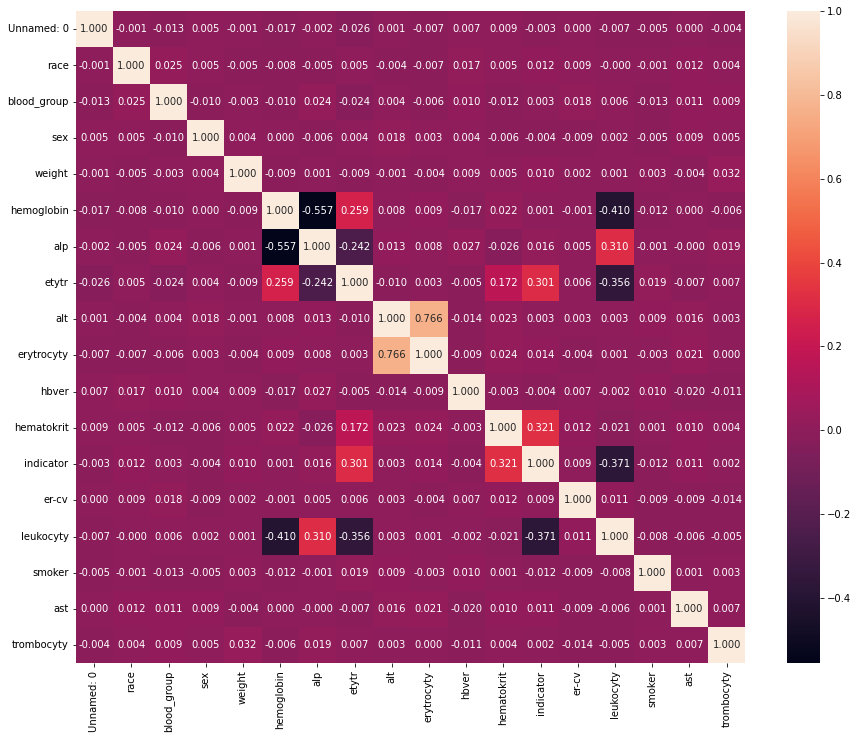

In [11]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".3f")

Po odstránení chýbajúcich hodnôt sa nič významné nezmienilo

#### Nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN

In [12]:
na_cols = ["hemoglobin", "alp", "etytr", "alt", "erytrocyty", "hbver", "hematokrit", "er-cv", "leukocyty", "ast", "trombocyty"] 

In [13]:
def sex_diff(col):
    print("M ", col, ": ", data[data["sex"] == 0][col].mean())
    print("F ", col, ": ", data[data["sex"] == 1][col].mean())

In [14]:
for col in na_cols: sex_diff(col)

M  hemoglobin :  7.604889637769638
F  hemoglobin :  7.605725715697905
M  alp :  49.32160059577064
F  alp :  48.98991685001979
M  etytr :  7.19210237901586
F  etytr :  7.20657389394539
M  alt :  4.951047994298514
F  alt :  5.135469456521739
M  erytrocyty :  7.614113399104963
F  erytrocyty :  7.620092197389241
M  hbver :  7.62686171515768
F  hbver :  7.634815333201503
M  hematokrit :  8.408990744810746
F  hematokrit :  8.390769703440096
M  er-cv :  52.5918286103764
F  er-cv :  52.357381518686964
M  leukocyty :  8.045340751068593
F  leukocyty :  8.05090972326547
M  ast :  47.99863934106162
F  ast :  48.224092356083084
M  trombocyty :  7.614753029501526
F  trombocyty :  7.625478938105597


In [15]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data)

TypeError: invalid type promotion

### Vychýlené dáta

#### Odstránenie vychýlených (odľahlých) pozorovaní

#### Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

## 2. Realizácia predspracovania dát (5b)


* Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
* Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

## 3. Výber atribútov pre strojové učenie (5b)

* Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

## 4. Replikovateľnosť predspracovania (5b)

* Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
* Očakáva sa aj využitie možnosti sklearn.pipeline

Správa sa odovzdáva v 9. týždni semestra

Na cvičení, dvojica svojmu cvičiacemu odprezentuje vykonanú prieskumnú analýzu v Jupyter Notebooku.
Správu elektronicky odovzdá jeden člen z dvojice do systému AIS do nedele 21.11.2021 23:59.